In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install transformers datasets rouge-score accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 66.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 42.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 99.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.7 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24932 sha256=4a4371597c7a6b306d45d258558c24f9db50ec6d0ac42e408d0a7eaf76f3930a
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8

In [ ]:
from pathlib import Path
import torch
import pprint

pp = pprint.PrettyPrinter(width=80, compact=True)
FOLDER_PATH = Path("/content/drive/MyDrive/FinTech Society News Summaries Project")
T5_SMALL_PATH = Path("finetuned-t5-small.pt")
T5_BASE_PATH = Path("finetuned-base-t5.pt")
T5_LARGE_PATH = Path("finetuned-t5-small.pt")
BART_BASE_PATH = Path("finetuned-bart-base.pt")
BART_LARGE_PATH = Path("finetuned-bart-large.pt")

t5_small_model= torch.load(FOLDER_PATH / T5_SMALL_PATH)
t5_base_model = torch.load(FOLDER_PATH / T5_BASE_PATH)
t5_large_model = torch.load(FOLDER_PATH / T5_LARGE_PATH)
bart_base_model = torch.load(FOLDER_PATH / BART_BASE_PATH)
bart_large_model = torch.load(FOLDER_PATH / BART_LARGE_PATH)

models = [t5_small_model, t5_base_model, t5_large_model, bart_base_model, bart_large_model]

In [ ]:
import datasets
metric = datasets.load_metric("rouge")
dataset = datasets.load_dataset("cnn_dailymail", "3.0.0")


<ipython-input-4-95b914193a7c>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = datasets.load_metric("rouge")


Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

In [ ]:
from transformers import (
    AutoTokenizer, BartTokenizer, DataCollatorForSeq2Seq
)

t5_small_tokenizer = AutoTokenizer.from_pretrained("t5-small")
t5_base_tokenizer = AutoTokenizer.from_pretrained("t5-base")
t5_large_tokenizer = AutoTokenizer.from_pretrained("t5-large")
bart_base_tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
bart_large_tokenizer = BartTokenizer.from_pretrained("facebook/bart-large")

tokenizers = [t5_small_tokenizer, t5_base_tokenizer, t5_large_tokenizer, bart_base_tokenizer, bart_large_tokenizer]

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5_fast.py:158: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5_fast.py:158: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this beh

In [ ]:
def preprocess(examples, tokenizer, max_input_length, max_output_length):
    article_split = examples["article"]
    labels_split = examples["highlights"]

    model_inputs = tokenizer(
        article_split,
        max_length=max_input_length,
        truncation=True,
        padding=True
      )

    labels = tokenizer(
        labels_split,
        max_length=max_output_length,
        truncation=True,
        padding=True
      )

    model_inputs["labels"] = labels["input_ids"]
    return {
        "attention_mask": model_inputs["attention_mask"],
        "input_ids": model_inputs["input_ids"],
        "labels": model_inputs["labels"]
    }

In [ ]:
T5_MAX_INPUT_LENGTH, T5_MAX_OUTPUT_LENGTH = 2048, 100
BART_MAX_INPUT_LENGTH, BART_MAX_OUTPUT_LENGTH = 768, 100

reduced_train_dataset = dataset["train"].select(range(10000))
reduced_val_dataset = dataset["validation"].select(range(1000))

tokenized_reduced_train_t5_small = reduced_train_dataset.map(lambda x: preprocess(x, t5_small_tokenizer, T5_MAX_INPUT_LENGTH, T5_MAX_OUTPUT_LENGTH), batched=True, remove_columns=["article", "highlights", "id"])
tokenized_reduced_train_t5_base = reduced_train_dataset.map(lambda x: preprocess(x, t5_base_tokenizer, T5_MAX_INPUT_LENGTH, T5_MAX_OUTPUT_LENGTH), batched=True, remove_columns=["article", "highlights", "id"])
tokenized_reduced_train_t5_large = reduced_train_dataset.map(lambda x: preprocess(x, t5_large_tokenizer, T5_MAX_INPUT_LENGTH, T5_MAX_OUTPUT_LENGTH), batched=True, remove_columns=["article", "highlights", "id"])
tokenized_reduced_train_bart_base = reduced_train_dataset.map(lambda x: preprocess(x, bart_base_tokenizer, BART_MAX_INPUT_LENGTH, BART_MAX_OUTPUT_LENGTH), batched=True, remove_columns=["article", "highlights", "id"])
tokenized_reduced_train_bart_large = reduced_train_dataset.map(lambda x: preprocess(x, bart_large_tokenizer, BART_MAX_INPUT_LENGTH, BART_MAX_OUTPUT_LENGTH), batched=True, remove_columns=["article", "highlights", "id"])

tokenized_reduced_eval_t5_small = reduced_val_dataset.map(lambda x: preprocess(x, t5_small_tokenizer, T5_MAX_INPUT_LENGTH, T5_MAX_OUTPUT_LENGTH), batched=True, remove_columns=["article", "highlights", "id"])
tokenized_reduced_eval_t5_base = reduced_val_dataset.map(lambda x: preprocess(x, t5_base_tokenizer, T5_MAX_INPUT_LENGTH, T5_MAX_OUTPUT_LENGTH), batched=True, remove_columns=["article", "highlights", "id"])
tokenized_reduced_eval_t5_large = reduced_val_dataset.map(lambda x: preprocess(x, t5_large_tokenizer, T5_MAX_INPUT_LENGTH, T5_MAX_OUTPUT_LENGTH), batched=True, remove_columns=["article", "highlights", "id"])
tokenized_reduced_eval_bart_base = reduced_val_dataset.map(lambda x: preprocess(x, bart_base_tokenizer, BART_MAX_INPUT_LENGTH, BART_MAX_OUTPUT_LENGTH), batched=True, remove_columns=["article", "highlights", "id"])
tokenized_reduced_eval_bart_large = reduced_val_dataset.map(lambda x: preprocess(x, bart_large_tokenizer, BART_MAX_INPUT_LENGTH, BART_MAX_OUTPUT_LENGTH), batched=True, remove_columns=["article", "highlights", "id"])

tokenized_reduced_train_datasets = [
  tokenized_reduced_train_t5_small,
  tokenized_reduced_train_t5_base,
  tokenized_reduced_train_t5_large,
  tokenized_reduced_train_bart_base,
  tokenized_reduced_train_bart_large
]

tokenized_reduced_eval_datasets = [
  tokenized_reduced_eval_t5_small,
  tokenized_reduced_eval_t5_base,
  tokenized_reduced_eval_t5_large,
  tokenized_reduced_eval_bart_base,
  tokenized_reduced_eval_bart_large
]

data_collators = [DataCollatorForSeq2Seq(tokenizers[i], models[i]) for i in range(len(models))]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
from torch.utils.data import DataLoader
for i in range(len(tokenized_reduced_train_datasets)):
  tokenized_reduced_train_datasets[i].set_format("torch")
  tokenized_reduced_eval_datasets[i].set_format("torch")

BATCH_SIZE = [8, 4, 1, 16, 12]
device = "cuda" if torch.cuda.is_available() else "cpu"

train_dataloaders = [DataLoader(ds, collate_fn=data_collators[i], batch_size=BATCH_SIZE[i]) for i, ds in enumerate(tokenized_reduced_train_datasets)]
eval_dataloaders = [DataLoader(ds, collate_fn=data_collators[i], batch_size=BATCH_SIZE[i]) for i, ds in enumerate(tokenized_reduced_eval_datasets)]

In [ ]:
import locale
from accelerate import Accelerator

locale.getpreferredencoding = lambda: "UTF-8"
accelerator = Accelerator()

In [ ]:
import nltk
nltk.download("punkt")

def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    # ROUGE expects a newline after each sentence
    preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

    return preds, labels

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from tqdm.auto import tqdm
import numpy as np
from transformers import AdamW

train_results, eval_results = [], []

for i in range(len(models)):
  model = models[i]
  train_dataloader = train_dataloaders[i]
  eval_dataloader = eval_dataloaders[i]
  optimizer = AdamW(model.parameters(), lr = 1e-4)
  model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
  )
  model = model.to(device)
  tokenizer = tokenizers[i]
  model.eval()

  for step, batch in enumerate(train_dataloader):
    batch = batch.to(device)
    with torch.no_grad():
      generated_tokens = accelerator.unwrap_model(model).generate(
            batch["input_ids"],
            attention_mask=batch["attention_mask"],
        )

      generated_tokens = accelerator.pad_across_processes(
          generated_tokens, dim=1, pad_index=tokenizer.pad_token_id
      )
      labels = batch["labels"]

      # If we did not pad to max length, we need to pad the labels too
      labels = accelerator.pad_across_processes(
          batch["labels"], dim=1, pad_index=tokenizer.pad_token_id
      )

      generated_tokens = accelerator.gather(generated_tokens).cpu().numpy()
      labels = accelerator.gather(labels).cpu().numpy()

      # Replace -100 in the labels as we can't decode them
      labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
      if isinstance(generated_tokens, tuple):
          generated_tokens = generated_tokens[0]
      decoded_preds = tokenizer.batch_decode(
          generated_tokens, skip_special_tokens=True
      )
      decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

      decoded_preds, decoded_labels = postprocess_text(
          decoded_preds, decoded_labels
      )

      metric.add_batch(predictions=decoded_preds, references=decoded_labels)

  result = metric.compute()
  result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
  result = {k: round(v, 4) for k, v in result.items()}
  train_results.append(result)

  for step, batch in enumerate(eval_dataloader):
    batch = batch.to(device)
    with torch.no_grad():
      generated_tokens = accelerator.unwrap_model(model).generate(
            batch["input_ids"],
            attention_mask=batch["attention_mask"],
        )

      generated_tokens = accelerator.pad_across_processes(
          generated_tokens, dim=1, pad_index=tokenizer.pad_token_id
      )
      labels = batch["labels"]

      # If we did not pad to max length, we need to pad the labels too
      labels = accelerator.pad_across_processes(
          batch["labels"], dim=1, pad_index=tokenizer.pad_token_id
      )

      generated_tokens = accelerator.gather(generated_tokens).cpu().numpy()
      labels = accelerator.gather(labels).cpu().numpy()

      # Replace -100 in the labels as we can't decode them
      labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
      if isinstance(generated_tokens, tuple):
          generated_tokens = generated_tokens[0]
      decoded_preds = tokenizer.batch_decode(
          generated_tokens, skip_special_tokens=True
      )
      decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

      decoded_preds, decoded_labels = postprocess_text(
          decoded_preds, decoded_labels
      )

      metric.add_batch(predictions=decoded_preds, references=decoded_labels)

  result = metric.compute()
  result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
  result = {k: round(v, 4) for k, v in result.items()}
  eval_results.append(result)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1417: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation

In [ ]:
pp.pprint(train_results)
pp.pprint(eval_results)

[{'rouge1': 23.1991,
  'rouge2': 10.5168,
  'rougeL': 19.4276,
  'rougeLsum': 21.9186},
 {'rouge1': 29.192, 'rouge2': 17.3995, 'rougeL': 25.7923, 'rougeLsum': 28.1354},
 {'rouge1': 23.1991,
  'rouge2': 10.5168,
  'rougeL': 19.4276,
  'rougeLsum': 21.9186},
 {'rouge1': 27.7202,
  'rouge2': 16.5205,
  'rougeL': 24.4633,
  'rougeLsum': 26.6988},
 {'rouge1': 30.409, 'rouge2': 20.7884, 'rougeL': 27.5918, 'rougeLsum': 29.5145}]
[{'rouge1': 22.888, 'rouge2': 8.8717, 'rougeL': 18.7894, 'rougeLsum': 20.9934},
 {'rouge1': 24.7249,
  'rouge2': 10.5649,
  'rougeL': 20.6204,
  'rougeLsum': 22.6979},
 {'rouge1': 22.888, 'rouge2': 8.8717, 'rougeL': 18.7894, 'rougeLsum': 20.9934},
 {'rouge1': 22.8305, 'rouge2': 9.491, 'rougeL': 19.1704, 'rougeLsum': 21.2012},
 {'rouge1': 23.4058, 'rouge2': 9.8196, 'rougeL': 19.4102, 'rougeLsum': 21.4789}]


In [ ]:
from google.colab import runtime
runtime.unassign()

In [ ]:
T5_SMALL_RESULTS = [
  {'rouge1': 22.9484, 'rouge2': 8.6608, 'rougeL': 18.8287, 'rougeLsum': 21.0089},
  {'rouge1': 22.7308, 'rouge2': 8.85, 'rougeL': 18.8137, 'rougeLsum': 21.0389},
  {'rouge1': 22.3776, 'rouge2': 8.6405, 'rougeL': 18.3665, 'rougeLsum': 20.5714},
  {'rouge1': 22.7604, 'rouge2': 8.7571, 'rougeL': 18.7353, 'rougeLsum': 20.9568},
  {'rouge1': 22.8955, 'rouge2': 8.8674, 'rougeL': 18.7722, 'rougeLsum': 21.0433}
]

T5_BASE_RESULTS = [
  {'rouge1': 24.1725, 'rouge2': 9.9193, 'rougeL': 20.1293, 'rougeLsum': 22.2994},
  {'rouge1': 24.4458, 'rouge2': 10.3268, 'rougeL': 20.3687, 'rougeLsum': 22.6078},
  {'rouge1': 24.5264, 'rouge2': 10.246, 'rougeL': 20.3284, 'rougeLsum': 22.5756},
  {'rouge1': 24.2816, 'rouge2': 10.2497, 'rougeL': 20.2482, 'rougeLsum': 22.3621},
  {'rouge1': 24.7187, 'rouge2': 10.5633, 'rougeL': 20.6125, 'rougeLsum': 22.693}
]

T5_LARGE_RESULTS = [
  {'rouge1': 23.752, 'rouge2': 9.5077, 'rougeL': 19.7442, 'rougeLsum': 21.8512},
  {'rouge1': 23.926, 'rouge2': 9.26, 'rougeL': 19.4868, 'rougeLsum': 21.9715},
  {'rouge1': 23.9771, 'rouge2': 9.4195, 'rougeL': 19.7168, 'rougeLsum': 21.9754},
  {'rouge1': 23.5491, 'rouge2': 9.185, 'rougeL': 19.3963, 'rougeLsum': 21.6374},
  {'rouge1': 24.0196, 'rouge2': 9.648, 'rougeL': 19.9147, 'rougeLsum': 22.0486}
]

BART_LARGE_RESULTS = [
  {'rouge1': 23.0847, 'rouge2': 9.5761, 'rougeL': 19.3544, 'rougeLsum': 21.2192},
  {'rouge1': 22.296, 'rouge2': 9.5221, 'rougeL': 18.7969, 'rougeLsum': 20.642},
  {'rouge1': 23.1146, 'rouge2': 9.939, 'rougeL': 19.442, 'rougeLsum': 21.3431},
  {'rouge1': 23.4268, 'rouge2': 9.7363, 'rougeL': 19.4775, 'rougeLsum': 21.4599},
  {'rouge1': 23.4293, 'rouge2': 9.8499, 'rougeL': 19.4313, 'rougeLsum': 21.5058}
]

BART_BASE_RESULTS = [
  {'rouge1': 22.8282, 'rouge2': 9.2263, 'rougeL': 19.032, 'rougeLsum': 21.1967},
  {'rouge1': 22.6134, 'rouge2': 9.6175, 'rougeL': 19.1242, 'rougeLsum': 21.0171},
  {'rouge1': 23.31, 'rouge2': 9.6181, 'rougeL': 19.5538, 'rougeLsum': 21.6684},
  {'rouge1': 23.416, 'rouge2': 9.6271, 'rougeL': 19.4492, 'rougeLsum': 21.6326},
  {'rouge1': 23.2365, 'rouge2': 9.6987, 'rougeL': 19.4985, 'rougeLsum': 21.5544}
]

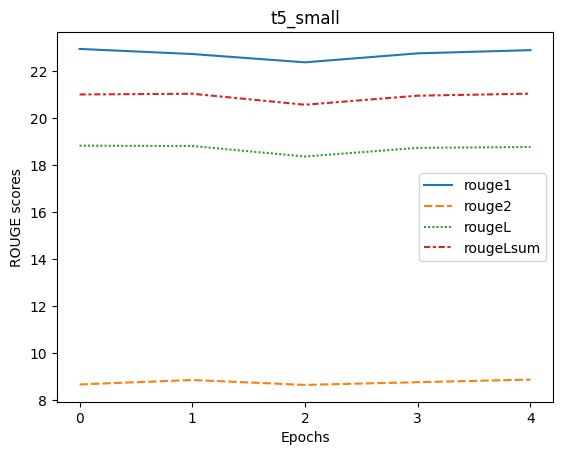

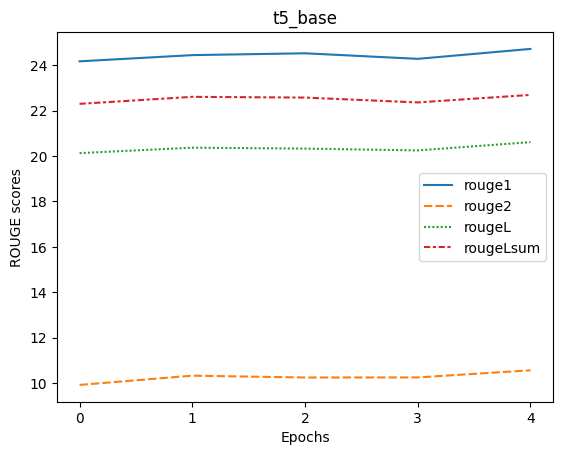

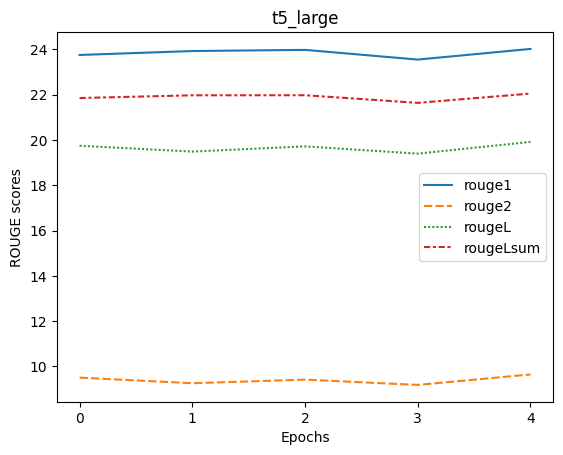

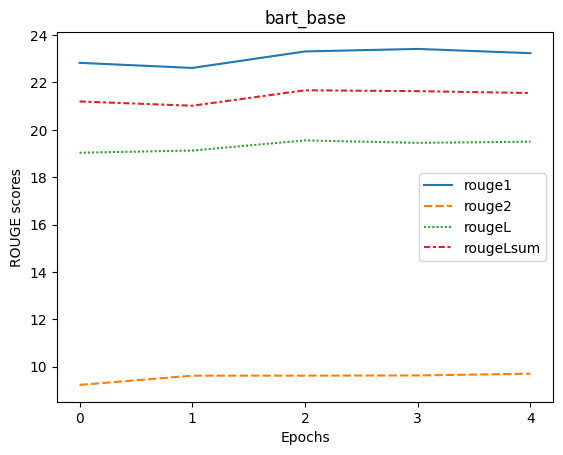

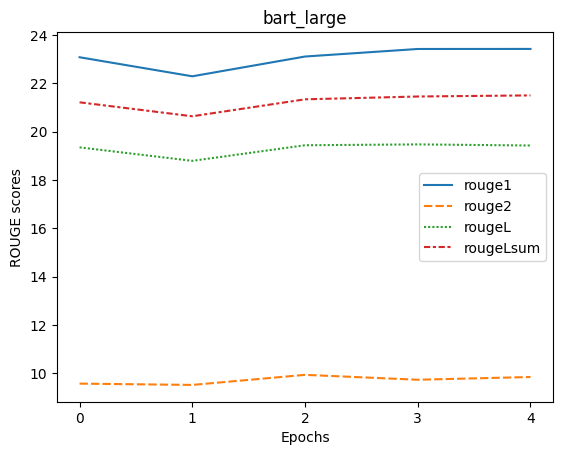

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
model_results = {"t5_small": T5_SMALL_RESULTS, "t5_base": T5_BASE_RESULTS, "t5_large": T5_LARGE_RESULTS, "bart_base": BART_BASE_RESULTS, "bart_large": BART_LARGE_RESULTS}
for model_name, model_result in model_results.items():
  model_df = pd.DataFrame.from_records(model_result)
  sns.lineplot(data=model_df)
  plt.title(model_name)
  plt.xlabel("Epochs")
  plt.xticks(range(5))
  plt.ylabel("ROUGE scores")
  plt.show()


In [ ]:
from google.colab import runtime
runtime.unassign()